# 库导入

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn
from sklearn.metrics import classification_report
import talib as ta
from sympy import *
import re

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 100 #图片像素
plt.rcParams['figure.dpi'] = 100 #分辨率

# pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# 分析框架

## 分析函数

In [2]:
### 分析函数 - 计算各类指标
def Indicator(equity_df,strategy_name):
    '''
    输入净值序列，一列净值，index为日期；策略名称
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    trade_len = (equity_df['日期'].tolist()[-1] - equity_df['日期'].tolist()[0]).days
    df['return'] = df[strategy_name[:-3]+'Ret']
    df['drawdown'] = 1-df[strategy_name]/df[strategy_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[strategy_name].tolist()[-1]/df[strategy_name].tolist()[0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = (cum_return+1)**(365.25/trade_len)-1
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
#     # 每年收益率
#     df_equity = df[[strategy_name]].copy()
#     df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:strategy_name})
    # 最大回撤结束、开始时间，持续时长
    max_drawdown_end = df['日期'][df['drawdown'].idxmax()]
    max_drawdown_end_str = max_drawdown_end.strftime('%Y-%m-%d')
    df_before_max_drawdowm = df[df['日期']<=max_drawdown_end].copy()
    max_drawdown_start = df_before_max_drawdowm[df_before_max_drawdowm['drawdown'] == 0]['日期'].tolist()[-1]
    max_drawdown_start_str = max_drawdown_start.strftime('%Y-%m-%d')
    max_drawdown_year = (max_drawdown_end - max_drawdown_start).days/365.25

    output_dict = {
                   '策略名称':[strategy_name],
                   '累计收益':[cum_return],
                   '年化收益':[mean_return],
                   '年化波动':[vol_return],
                   'IR':[IR],
                   '夏普比率':[sharpe_ratio],
                   '最大回撤':[max_drawdown],
                   '收益回撤比':[mean_return_max_drawdown_ratio],
                   '最大回撤开始':[max_drawdown_start_str],
                   '最大回撤结束':[max_drawdown_end_str],
                   '最大回撤持续':[max_drawdown_year],
                  }
    output_df = pd.DataFrame(output_dict).T
#     return output_df, df
    return output_df.T

## 技术分析指标计算

In [3]:
###################### MA系列 ######################
def MAcompute(Data,By,Params):
    df=Data.copy()
    L = Params['L']
    S = Params['S']
    df['MA%s'%(L)] = df['收盘价'].rolling(L).mean()
    df['MA%s'%(S)] = df['收盘价'].rolling(S).mean()
    df['MA%s_MA%s'%(S,L)] = df['MA%s'%(S)]-df['MA%s'%(L)]
    df['MA%s_MA%s_signal'%(S,L)] \
    = df['MA%s_MA%s'%(S,L)].apply(lambda x: 1 if x>0 else 0 if x<0 else x)
    return df[['日期',By,'收盘价','MA%s_MA%s_signal'%(S,L)]].copy()

## 统一调用函数

In [4]:
def Signal(Data, By, Params, Fun):
    '''
    Data, pandas.DataFrame, colnames：包含['品种','日期','收盘价','开盘价','最高价','最低价']等，根据需要,
    By, String, 不同品种分组标识, 一般为股票代码,
    Params, 计算该技术指标所需参数, 字典形式传输,
    Fun, 用以计算指标的函数,
    '''
    DataSignal=Data.groupby(By).apply(Fun,By,Params).reset_index(drop=True)
    Sname=DataSignal.columns[-1]
    return DataSignal, Sname

In [133]:
By = '品种'
Params_MA = {'S':5,'L':60}
Fun=MAcompute
Data = pd.read_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/均线策略数据库.xlsx',parse_dates=['日期'])

In [134]:
Tec_Signal, Sname=Signal(Data, By, Params=Params_MA, Fun=MAcompute)

## 限制做空的日度策略

In [135]:
# 策略收益与净值计算
def RetCompute(Data,By, Sname):
    def Ret(df,Sname):
        df_=df.sort_values('日期')
        df_['Ret']=df_['收盘价']/df_['收盘价'].shift(1)-1
        df_['%s_Ret'%(Sname)]=df_['Ret']*(df_[Sname].shift(1))
        df_['%s_Eqt'%(Sname)]=(df_['%s_Ret'%(Sname)].fillna(0)+1).cumprod()
        return df_
    DataRet=Data.groupby(By).apply(Ret,Sname=Sname).reset_index(drop=True)
    return DataRet

In [136]:
# 多指标输出
def ResultOutput(Sname,Data,By):
    Data=Data.copy()
    EqtSname = '%s_Eqt'%(Sname)
    RetStrategy = RetCompute(Data,By, Sname)
    Result=RetStrategy.groupby(By).apply(Indicator,EqtSname)
    Result.index=Result.index.droplevel(1)
    Result=Result.reset_index()
    return Result, RetStrategy

In [197]:
# 简单指标输出 - 最好是单品种
def SimResultOutput(Sname,Data,By):
    Data=Data.copy()
    EqtSname = '%s_Eqt'%(Sname)
    RetSname = '%s_Ret'%(Sname)
    RetStrategy = RetCompute(Data,By, Sname)
    def SimInd(Data,EqtSname,RetSname):
        Data_=Data.copy()
        # 年化收益率平均
        # 累计收益
        cum_return = Data_[EqtSname].tolist()[-1]/Data_[EqtSname].tolist()[0]-1
        trade_len = (Data_['日期'].tolist()[-1] - Data_['日期'].tolist()[0]).days
        mean_return = (cum_return+1)**(365.25/trade_len)-1
        # 年化收益率波动
        vol_return = Data_[RetSname].std()*np.sqrt(252)
        # IR
        IR = mean_return/vol_return
        return pd.DataFrame({
                   '策略名称':[EqtSname],
                   '年化收益':[mean_return],
                   '年化波动':[vol_return],
                   'IR':[IR],
                  })
    SimResult=RetStrategy.groupby(By).apply(SimInd,EqtSname=EqtSname,RetSname=RetSname)
    SimResult.index=SimResult.index.droplevel(1)
    SimResult=SimResult.reset_index()
    return SimResult

In [195]:
%%time
SimResultOutput(Sname,Tec_Signal,By)

Wall time: 24.9 ms


,品种,策略名称,IR
0,沪深300,MA99_MA100_signal_Eqt,0.834604


In [141]:
%%time
IndResult, DataResult=ResultOutput(Sname,Tec_Signal,By)

In [142]:
IndResult

,品种,策略名称,累计收益,年化收益,年化波动,IR,夏普比率,最大回撤,收益回撤比,最大回撤开始,最大回撤结束,最大回撤持续
0,沪深300,MA5_MA60_signal_Eqt,10.2279,0.18014,0.187438,0.961066,0.801013,0.376918,0.477929,2009-08-03,2014-07-10,4.93361
1,美元兑人民币,MA5_MA60_signal_Eqt,0.219038,0.0136523,0.0172441,0.791705,-0.948019,0.0335174,0.407318,2005-11-17,2012-05-11,6.48049
2,道琼斯工业指数,MA5_MA60_signal_Eqt,0.464754,0.0264759,0.0987965,0.267984,-0.0356706,0.237321,0.111562,2007-07-19,2009-04-07,1.71937


In [143]:
DataResult

,日期,品种,收盘价,MA5_MA60_signal,Ret,MA5_MA60_signal_Ret,MA5_MA60_signal_Eqt
0,2005-01-04,沪深300,982.794,NaN,NaN,NaN,1.000000
1,2005-01-05,沪深300,992.564,NaN,0.009941,NaN,1.000000
2,2005-01-06,沪深300,983.174,NaN,-0.009460,NaN,1.000000
3,2005-01-07,沪深300,983.958,NaN,0.000797,NaN,1.000000
4,2005-01-10,沪深300,993.879,NaN,0.010083,NaN,1.000000
...,...,...,...,...,...,...,...
10652,2019-08-08,道琼斯工业指数,26378.190,0.0,0.014270,0.0,1.464754
10653,2019-08-09,道琼斯工业指数,26287.440,0.0,-0.003440,-0.0,1.464754
10654,2019-08-12,道琼斯工业指数,25907.370,0.0,-0.014458,-0.0,1.464754
10655,2019-08-13,道琼斯工业指数,26279.910,0.0,0.014380,0.0,1.464754


# 单指数分析

## 单参数业绩表现

### 整体表现 - 收益波动回撤

In [198]:
DataUsed=Data[Data['品种']=='沪深300'].copy()
DataUsed=Data.copy()
By = '品种'
Params_MA = {'S':5,'L':60}
Fun=MAcompute

In [199]:
# 回测结果输出
Tec_Signal, Sname=Signal(DataUsed, By, Params=Params_MA, Fun=MAcompute)
Eqtname, Retname = '%s_Eqt'%(Sname),'%s_Ret'%(Sname)
ResultInd, ResultData = ResultOutput(Sname,Tec_Signal,By)

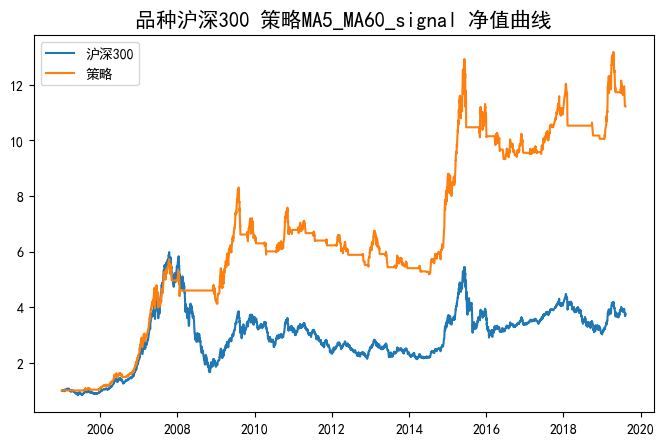

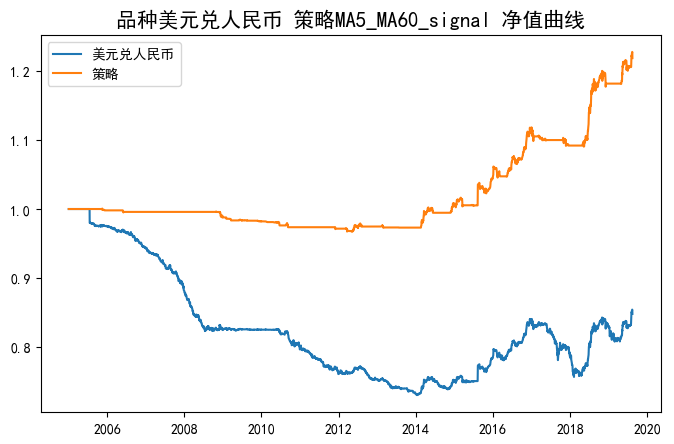

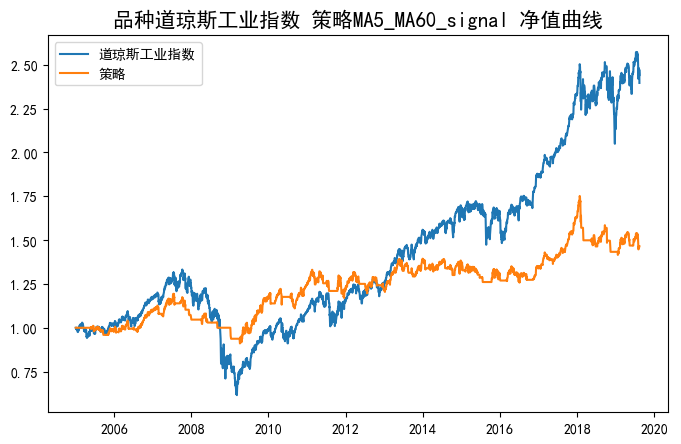

,0,1,2
品种,沪深300,美元兑人民币,道琼斯工业指数
策略名称,MA5_MA60_signal_Eqt,MA5_MA60_signal_Eqt,MA5_MA60_signal_Eqt
累计收益,10.2279,0.219038,0.464754
年化收益,0.18014,0.0136523,0.0264759
年化波动,0.187438,0.0172441,0.0987965
IR,0.961066,0.791705,0.267984
夏普比率,0.801013,-0.948019,-0.0356706
最大回撤,0.376918,0.0335174,0.237321
收益回撤比,0.477929,0.407318,0.111562
最大回撤开始,2009-08-03,2005-11-17,2007-07-19


In [224]:
# 回测结果绘图
codeList= ResultData[By].unique().tolist()
for codeN in range(len(codeList)):
    code=codeList[codeN]
    PlotData = ResultData[ResultData[By]==code].set_index('日期')[['收盘价',Eqtname]]
    PlotData['收盘价']=PlotData['收盘价']/PlotData['收盘价'].tolist()[0]
    # 绘图代码
    fig = plt.figure(figsize=(8,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(PlotData['收盘价'],label=code)
    ax1.plot(PlotData[Eqtname],label='策略')
    plt.title('品种%s 策略%s 净值曲线'%(code,Sname),fontsize=15)
    plt.legend(loc=0)
    plt.show()
ResultInd.T

### 信号切换频率

### 震荡市与行情市

In [ ]:
# 一种后验划分

## 策略稳健性

### 动态调整参数

In [208]:
# 生成待测参数
def MA_Params_Ger(N):
    Params_MA_List = []
    WindLimit = N
    for Swind in range(1,WindLimit):
        for Lwind in range(Swind+1,WindLimit+1):
            Params_MA_List.append({'S':Swind,'L':Lwind})
    return Params_MA_List

In [209]:
# 回测大量参数
def BackTest_Multi(DataUsed,N_MA, By,Fun):
    Params_MA_List = MA_Params_Ger(N_MA)
    ResultIndAll = pd.DataFrame()
    for Params_MA_each in Params_MA_List:
        Tec_Signal, Sname=Signal(DataUsed, By, Params=Params_MA_each, Fun=Fun)
        Eqtname, Retname = '%s_Eqt'%(Sname),'%s_Ret'%(Sname)
        ResultInd= SimResultOutput(Sname,Tec_Signal,By)
        ResultIndAll=pd.concat([ResultIndAll,ResultInd],axis=0)
    return ResultIndAll

In [225]:
N_MA = 150
How = 'MA'
ResultIndAll=BackTest_Multi(DataUsed,N_MA, By,Fun=MAcompute)

In [226]:
# 回测结果输出为矩阵形式
ResultMat_dct = {}
for name, df in ResultIndAll.groupby(By):
    df_=df.copy()
    paramsMat = pd.DataFrame(index=range(1,N_MA+1),columns=range(1,N_MA+1))
    nameList = df_['策略名称'].tolist()
    IR_List = df_['IR'].tolist()
    paramList=[re.findall('%s(\d+)'%(How),name) for name in nameList]
    for paramN in range(len(paramList)):
        param=paramList[paramN]
        paramsMat.loc[int(param[0]),int(param[1])]=IR_List[paramN]
    ResultMat_dct[name] = paramsMat

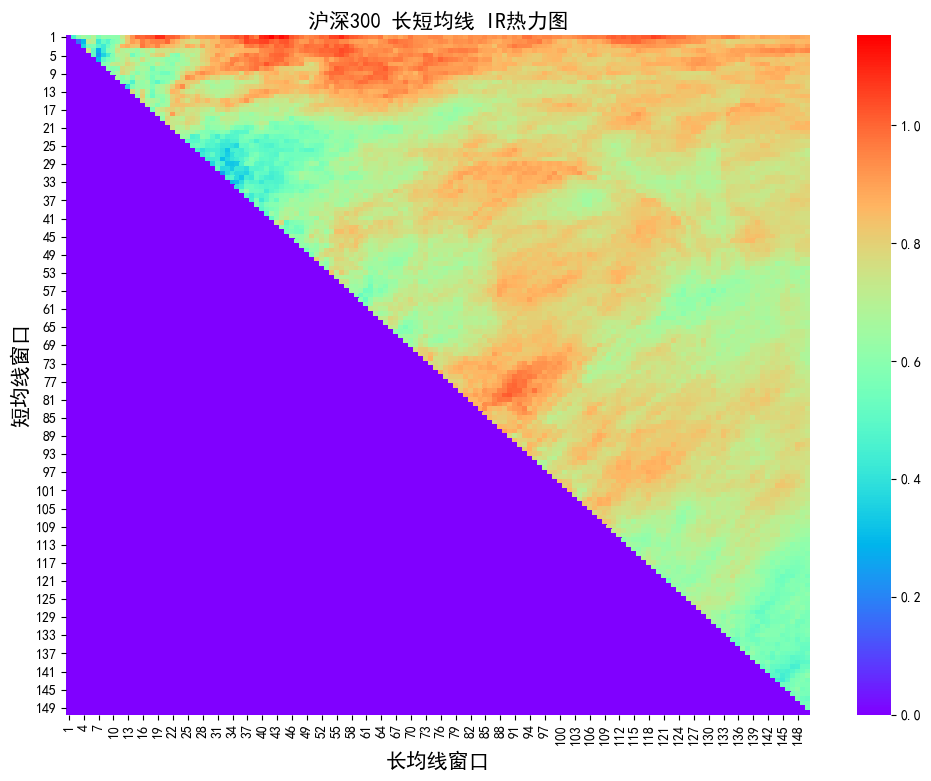

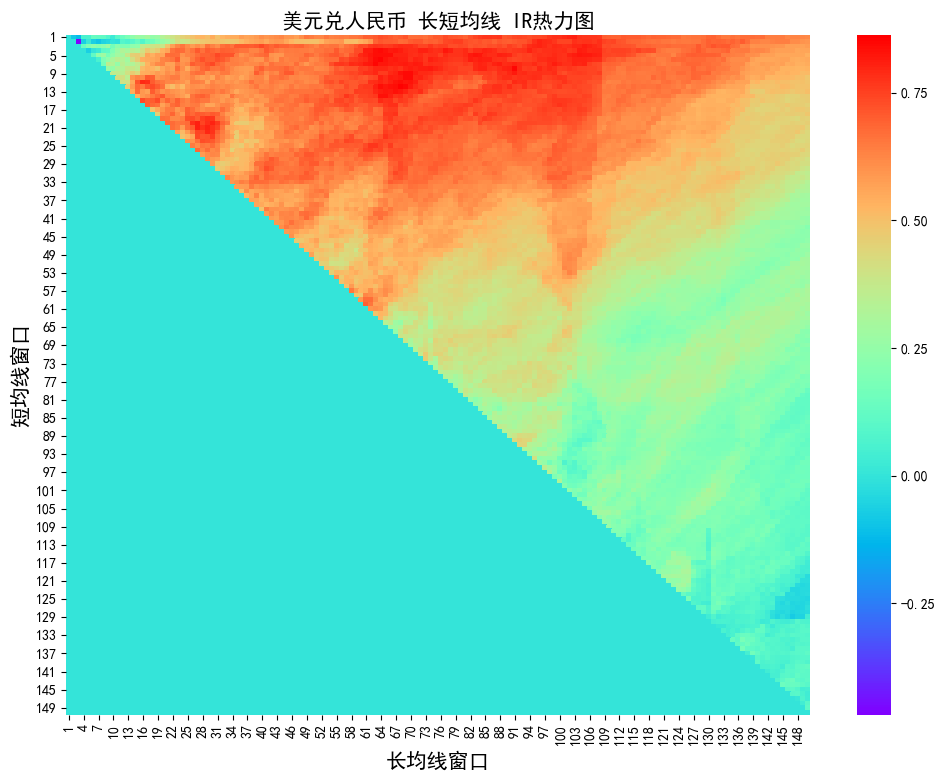

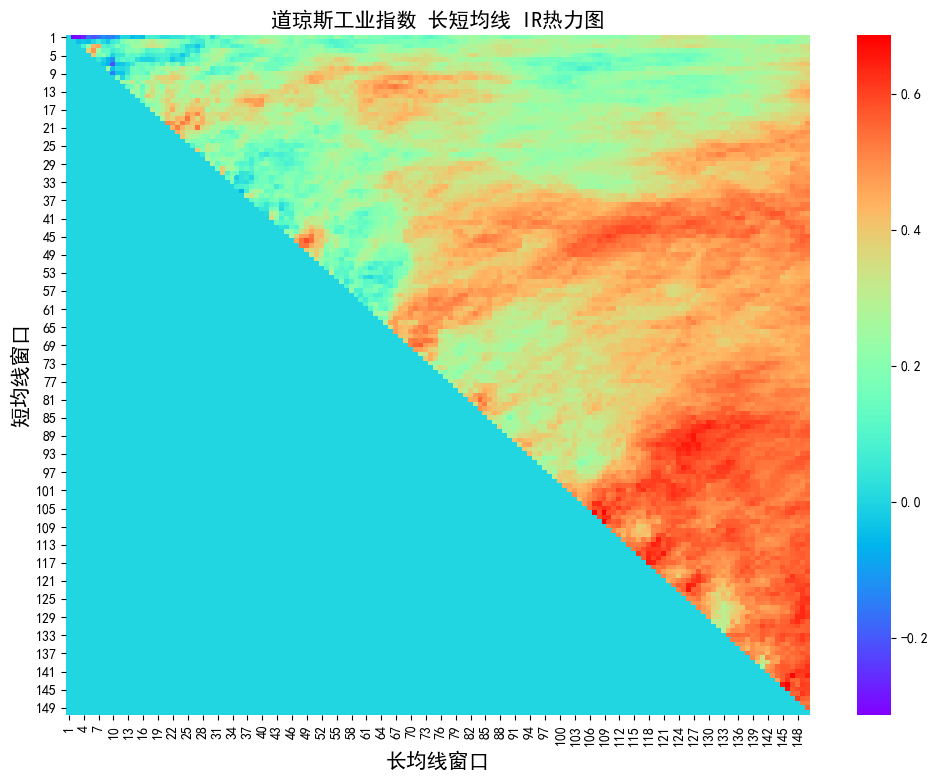

In [232]:
# 矩阵参数绘制热力图
for key in ResultMat_dct.keys():
    plt.figure(figsize=(12,9))
    ResultMat=ResultMat_dct[key].copy()
    seaborn.heatmap(ResultMat.fillna(0),cmap='rainbow')
    plt.xlabel('长均线窗口',fontsize=15)
    plt.ylabel('短均线窗口',fontsize=15)
    plt.title('%s 长短均线 IR热力图'%(key),fontsize=15)
    plt.show()

In [ ]:
### 个股上的表现

In [ ]:
### 蒙特卡洛模拟样本上的表现